In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torchvision.datasets import ImageFolder
from torchvision import models as models

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy, os
import random
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

root = '../'
code_folder = 'code'
models_saved_folder = 'saved_models'
all_data_folder = 'all_images'
data_folder = 'images'
train_images_foldr = 'train'
validation_images_foldr = 'val'
test_images_foldr = 'test'
os.makedirs(os.path.join(root, models_saved_folder), exist_ok=True)

In [4]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

# res50 = get_res50(pretrained=False, requires_grad=False, num_classes=9)
# res101 = get_res50(pretrained=False, requires_grad=False, num_classes=9)
# res152 = get_res50(pretrained=False, requires_grad=False, num_classes=9)

res50 = torch.load('materials_shaozuiyu_exp/tut3-model_res50.pt',map_location=torch.device('cpu'))
res101 = torch.load('materials_shaozuiyu_exp/tut3-model_res101.pt',map_location=torch.device('cpu'))
res152 = torch.load('materials_shaozuiyu_exp/tut3-model_res152.pt',map_location=torch.device('cpu'))

In [5]:
resize = 224
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
test_transforms = transforms.Compose([
                           transforms.Resize(resize),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean,
                                                std = std)
                       ])
test_set = ImageFolder(os.path.join(root, data_folder, test_images_foldr),transform=test_transforms)
print(f'Number of testing examples: {len(test_set)}')
test_iterator = data.DataLoader(test_set,
                                batch_size = 1)

Number of testing examples: 387


In [6]:
test_set.class_to_idx

{'douyumao': 0,
 'duobu': 1,
 'jinshi': 2,
 'lieshi': 3,
 'liyu': 4,
 'mishi': 5,
 'xiuqi': 6,
 'xiyu': 7,
 'zhenchi': 8}

In [10]:
device = 'cpu'
# res50
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

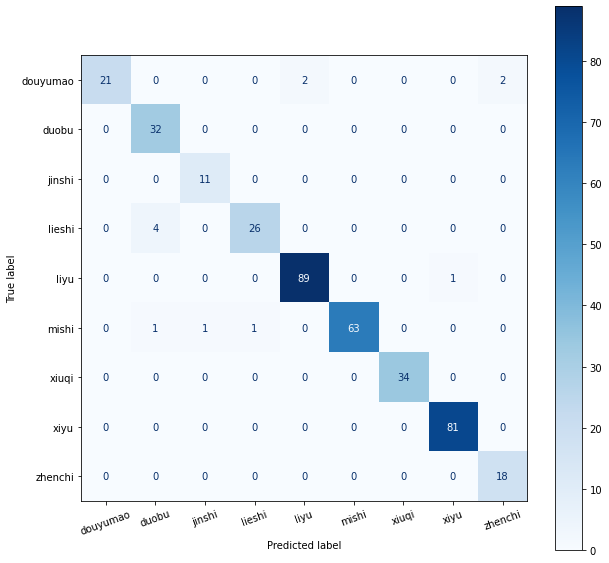

In [13]:
# get_predictions(model=res50, iterator=test_iterator, device=device)
images, labels, probs = get_predictions(res50, test_iterator, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels, test_set.classes) 

In [20]:
corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)
    
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [24]:
num_errors = len(incorrect_examples)

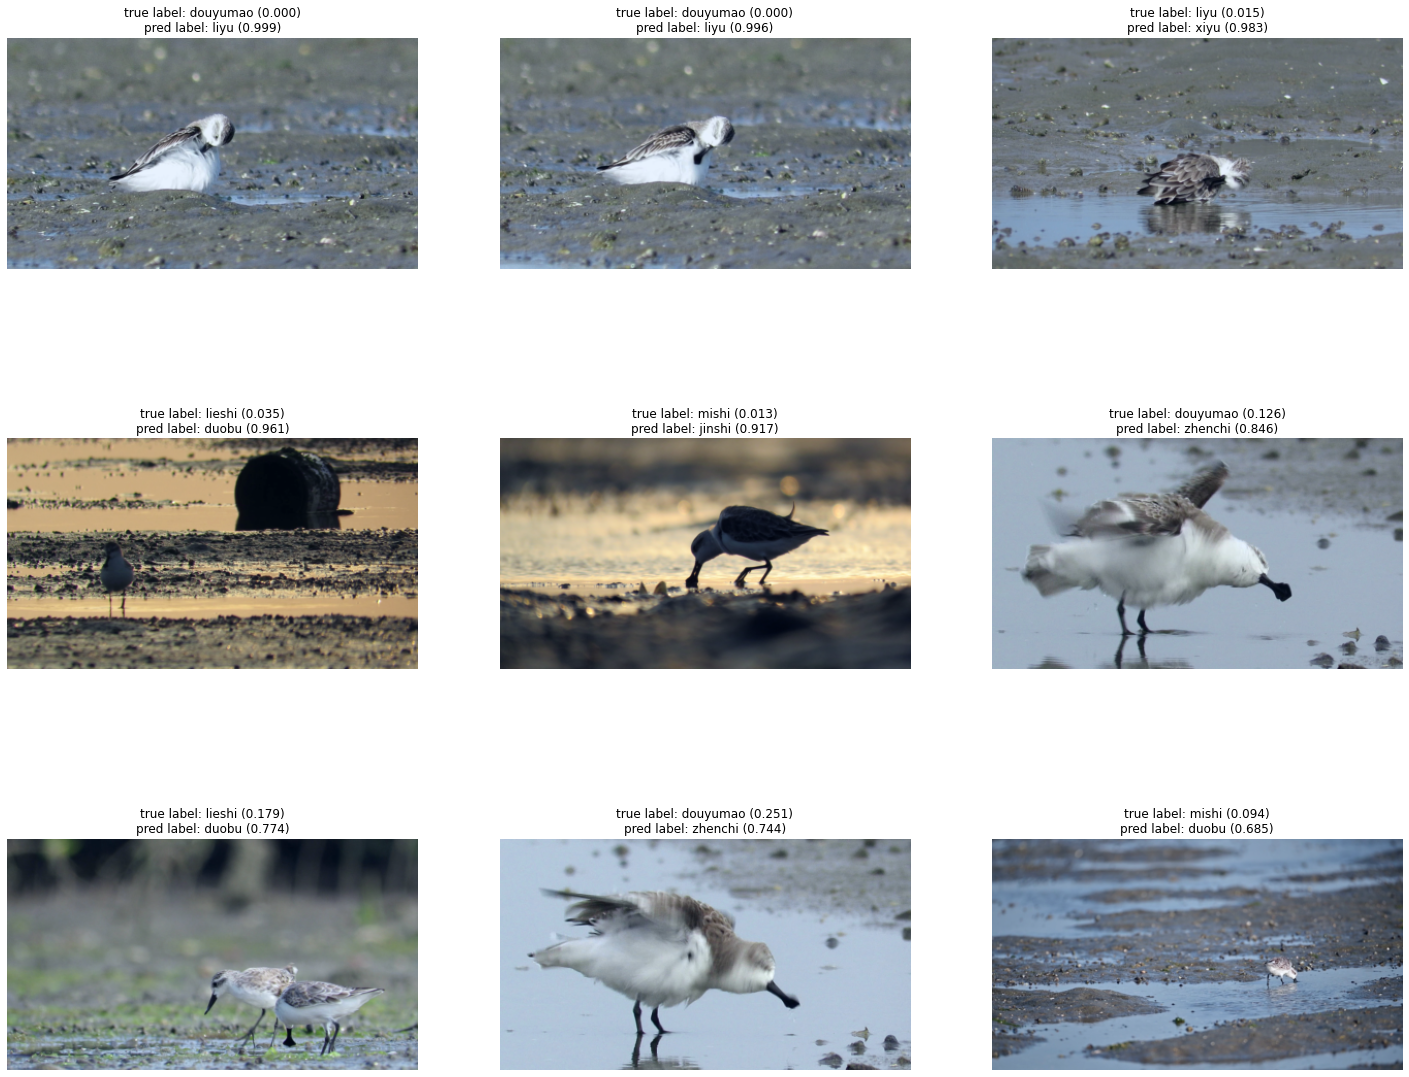

In [25]:
N_IMAGES = num_errors

plot_most_incorrect(incorrect_examples, test_set.classes, N_IMAGES)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
from scikitplot.metrics import plot_roc, plot_precision_recall
# images, labels, probs = get_predictions(res50, test_iterator, device)
# pred_labels = torch.argmax(probs, 1)
# plot_confusion_matrix(labels, pred_labels, test_set.classes) 
print(classification_report(y_true=labels, y_pred=pred_labels, target_names=test_set.classes))

              precision    recall  f1-score   support

    douyumao       1.00      0.84      0.91        25
       duobu       0.86      1.00      0.93        32
      jinshi       0.92      1.00      0.96        11
      lieshi       0.96      0.87      0.91        30
        liyu       0.98      0.99      0.98        90
       mishi       1.00      0.95      0.98        66
       xiuqi       1.00      1.00      1.00        34
        xiyu       0.99      1.00      0.99        81
     zhenchi       0.90      1.00      0.95        18

    accuracy                           0.97       387
   macro avg       0.96      0.96      0.96       387
weighted avg       0.97      0.97      0.97       387



In [38]:
import pandas as pd
# confusion_matrix_res50 = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=pred_labels), columns=test_set.classindex=test_set.classes)
confusion_matrix_res50 = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=pred_labels), index=test_set.classes, columns=test_set.classes)

confusion_matrix_res50

,douyumao,duobu,jinshi,lieshi,liyu,mishi,xiuqi,xiyu,zhenchi
douyumao,21,0,0,0,2,0,0,0,2
duobu,0,32,0,0,0,0,0,0,0
jinshi,0,0,11,0,0,0,0,0,0
lieshi,0,4,0,26,0,0,0,0,0
liyu,0,0,0,0,89,0,0,1,0
mishi,0,1,1,1,0,63,0,0,0
xiuqi,0,0,0,0,0,0,34,0,0
xiyu,0,0,0,0,0,0,0,81,0
zhenchi,0,0,0,0,0,0,0,0,18


In [46]:
test_set.class_to_idx

{'douyumao': 0,
 'duobu': 1,
 'jinshi': 2,
 'lieshi': 3,
 'liyu': 4,
 'mishi': 5,
 'xiuqi': 6,
 'xiyu': 7,
 'zhenchi': 8}

In [51]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        
        self.resnet = res50
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        
        # classifier
        self.classifier = self.resnet.fc
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)

        x = self.avgpool(x)
        h = x.view((1, -1))
        x = self.classifier(h)
        
        return x, h
     
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

def plot_representations(data, labels, classes, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')
    handles, _ = scatter.legend_elements(num = None)
    legend = plt.legend(handles = handles, labels = classes)
    
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

model = ResNet50()
outputs, labels = get_representations(model, test_iterator)

In [60]:
np.save('featues_from_res50', outputs,)
np.save('labels_from_res50', labels,)

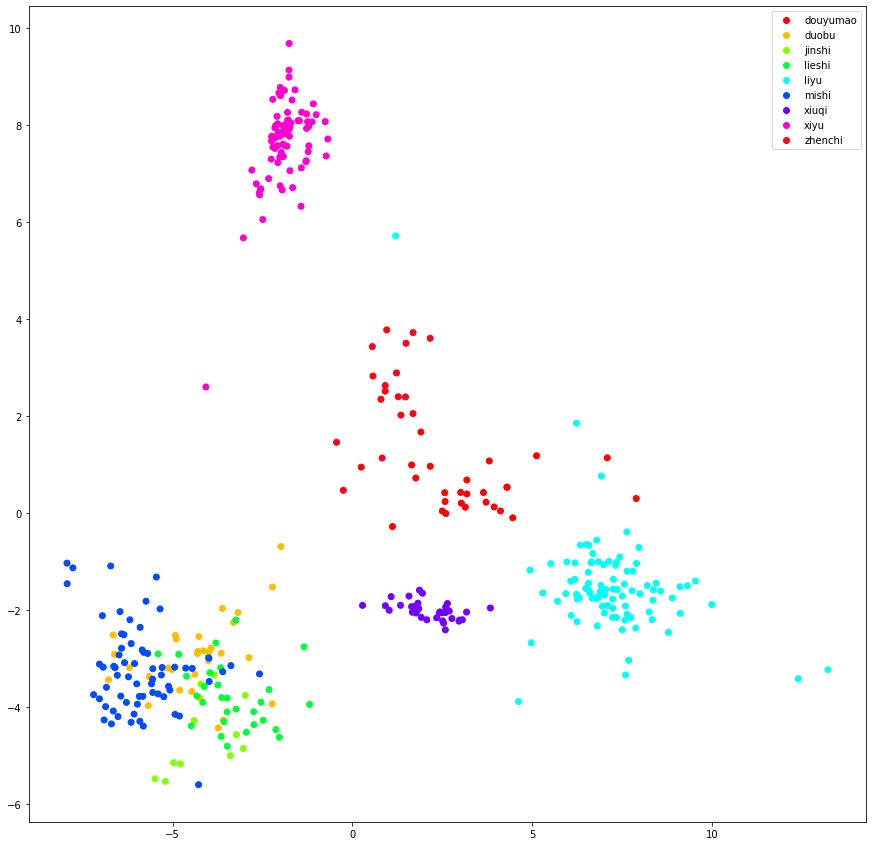

In [73]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, test_set.classes)

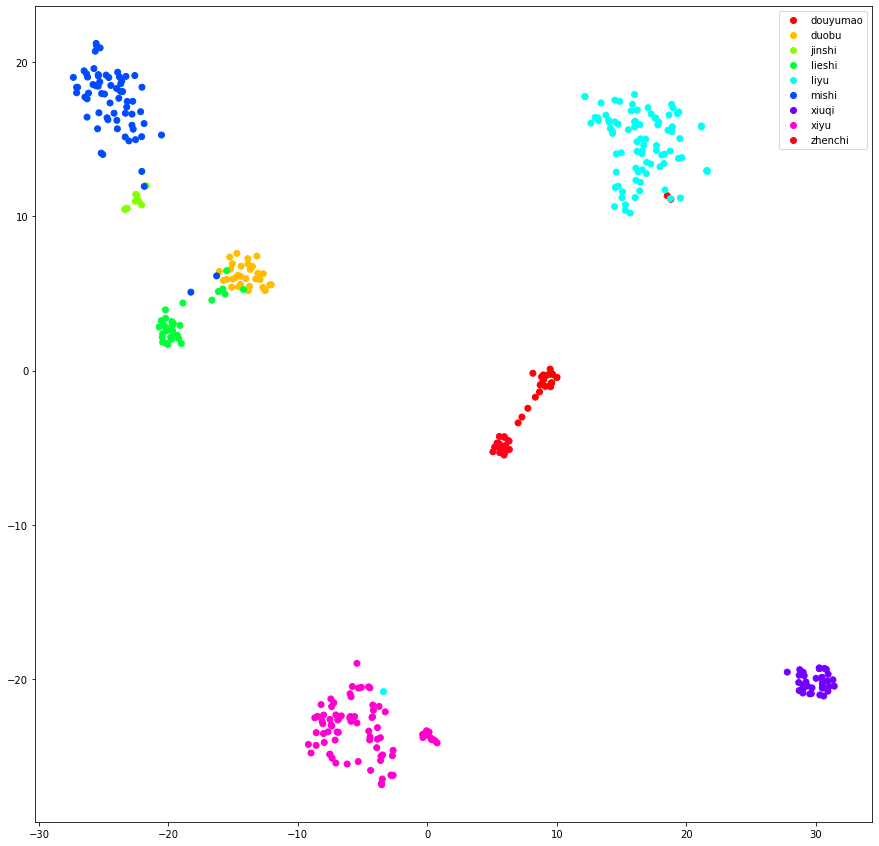

In [58]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, test_set.classes)

In [68]:
labels_from_res50 = np.load('./labels_from_res50.npy')
features_from_res50 = np.load('./featues_from_res50.npy')

labels_from_res101 = np.load('./labels_from_res101.npy')
features_from_res101 = np.load('./featues_from_res101.npy')

labels_from_res152 = np.load('./labels_from_res152.npy')
features_from_res152 = np.load('./featues_from_res152.npy')

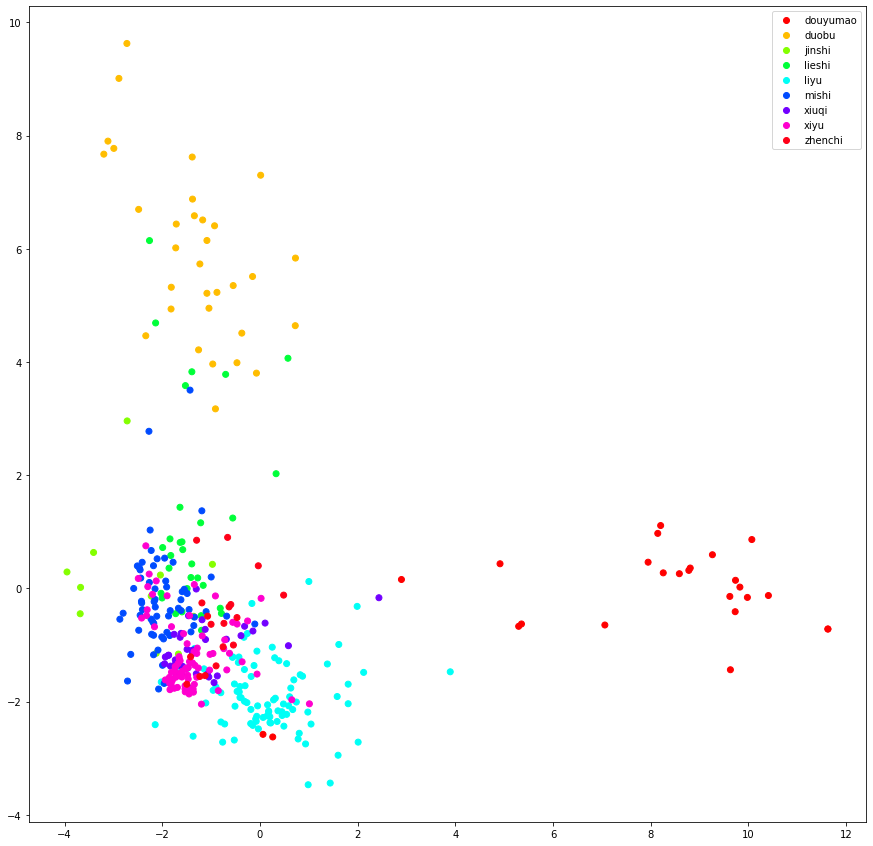

In [71]:
output_pca_data = get_pca(features_from_res50)
plot_representations(features_from_res50, labels_from_res50, test_set.classes)

In [ ]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, test_set.classes)